<a href="https://colab.research.google.com/github/trevorVlong/underactuated/blob/main/hopfield_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Welcome!  If you are new to Google Colab/Jupyter notebooks, you might take a look at [this notebook](https://colab.research.google.com/notebooks/basic_features_overview.ipynb) first.

**I recommend you run the first code cell of this notebook immediately, to start provisioning drake on the cloud machine, then you can leave this window open as you [read the textbook](http://underactuated.csail.mit.edu/intro.html).**

# Notebook Setup

The following cell will:
- on Colab (only), install Drake to `/opt/drake`, install Drake's prerequisites via `apt`, and add pydrake to `sys.path`.  This will take approximately two minutes on the first time it runs (to provision the machine), but should only need to reinstall once every 12 hours.  If you navigate between notebooks using Colab's "File->Open" menu, then you can avoid provisioning a separate machine for each notebook.
- import packages used throughout the notebook.

You will need to rerun this cell if you restart the kernel, but it should be fast (even on Colab) because the machine will already have drake installed.

In [4]:
import importlib
import sys
from urllib.request import urlretrieve

# Install drake (and underactuated).
if 'google.colab' in sys.modules and importlib.util.find_spec('underactuated') is None:
    urlretrieve(f"http://underactuated.csail.mit.edu/scripts/setup/setup_underactuated_colab.py",
                "setup_underactuated_colab.py")
    from setup_underactuated_colab import setup_underactuated
    setup_underactuated(underactuated_sha='1dca1b915977aeec9f327d61aaeac4cfb9c6b408', drake_version='0.25.0', drake_build='releases')

# Imports.
# python libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.image as mpimg
from matplotlib import rc
rc('animation', html='jshtml')

# pydrake imports
from pydrake.all import DiagramBuilder, Variable, SymbolicVectorSystem, LogOutput, Simulator
from pydrake.all import VectorSystem, BasicVector

# underactuated imports
from underactuated import plot_2d_phase_portrait



Cloning into '/opt/underactuated'...

HEAD is now at 1dca1b9 test hotfix for python3.7 on colab






## Problem Description
In this problem you will write the dynamics equation for the Hopfield network.
At the end of the notebook, you will be able to check your work in test cases we set up for you.

**These are the main steps of the exercise:**
1. Write the function "dynamics" that defines the differential equation. _You need to write a piece of code to implement the system dynamics._

2. Modify the system dynamics to memorize MNIST data. _You need to write a piece of code to modify the matrix $A$._


### Question (a) - (c)

Write the function for the dynamical system defined in the quesiton. This function should return the right-hand side of the dynamical equation: $$\dot{x} = A^T\,\text{softmax}(\beta\, A\, x) - x$$ Write the function to output $$A^T\,\text{softmax}(\beta\, A\, x) - x$$ given the state $x$, matrix $A$, and scalar $\beta$.

In [5]:
# We provide two helper functions: softmax and matrix-vector multiplication
def softmax(x, beta = 1):
  e_x = np.array([np.exp(beta*x[i]) for  i in range(len(x))])
  return e_x / e_x.sum(axis = 0)

def matrix_vector_multiplication(A, x):
  return [sum(a*b for a,b in zip(A_row,x)) for A_row in A]

def dynamics(x, A, beta):
    """outputs the right hand side of differential equation in Hopfield dynamical system.
    
    ARGUMENTS: x: numpy array of size n
               A: numpy array of size m by n
               beta: scalar
    RETURNS:   numpy array of size n
    """
    ################### Your solution goes here #######################
    ip = matrix_vector_multiplication(A,x)
    Asmax = matrix_vector_multiplication(A.T, softmax(ip,beta))

    return Asmax - np.array(x)
    
    ###################################################################



The cell below should plot the phase portrait if the function dynamics(x, A, beta) is implemented correctly.

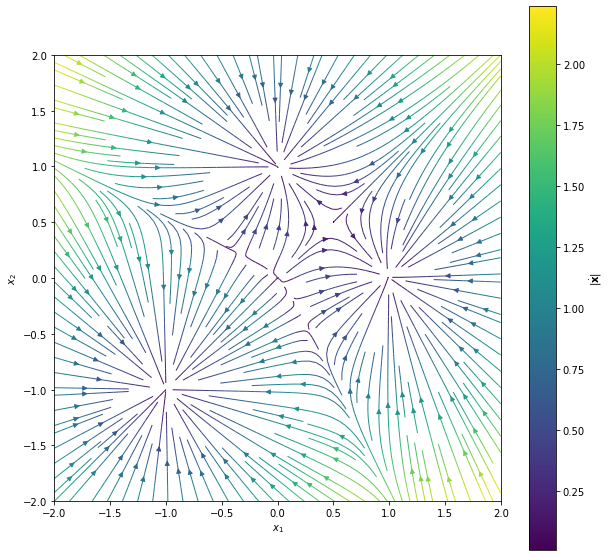

In [6]:
A = np.array([[1,0],[0,1],[-1,-1]])
beta = 5

# initialize plot and make it big enough
plt.figure(figsize=(10, 10))

# plot the phase portrait of the 2d system
plot_2d_phase_portrait((lambda x: dynamics(x, A, beta)), x1lim=[-2, 2], x2lim=[-2, 2], linewidth=1, density=2)

### Question (d)
In this question, we will modify the constant matrix $A$ to store a subset of the MNIST dataset. The MNIST dataset contains 28 by 28 images of hand-written numbers. Our objective is to restore the corrupted image using the training data. In the following cell, we load training data and corrupted images we want to restore. 

The variable `training_data` contains the four images that should be stored as the equilibriums to our dynamical system.

The variable `corrupted_img` contains a set of corrupted images that are used as the initial conditions.



Training Data


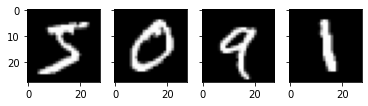

Corrupted Images


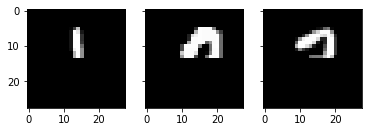

In [26]:
import torchvision.datasets as datasets
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True)

training_data = [np.array(mnist_trainset[0][0]), 
                 np.array(mnist_trainset[1][0]), 
                 np.array(mnist_trainset[4][0]), 
                 np.array(mnist_trainset[6][0])]

corrupted_img = [np.array(mnist_trainset[8][0]), 
                 np.array(mnist_trainset[34][0]), 
                 np.array(mnist_trainset[5][0])]

for i, item in enumerate(corrupted_img):
    corrupted_img[i][14:,:]=0

print("Training Data")
fig, ax = plt.subplots(1, 4, sharex='col', sharey='row')
for i, item in enumerate(training_data):
    ax[i].imshow(item,cmap='gray')
plt.show()

print("Corrupted Images")
fig, ax = plt.subplots(1, 3, sharex='col', sharey='row')
for i, item in enumerate(corrupted_img):
    ax[i].imshow(item,cmap='gray')
plt.show()


If we could design the Hopfield network to store the training data as its equilbriums, we can simulate the dynamical system to restore the image from the corrupted image.


Modify the matrix $A\in\mathbb{R}^{4\times 784}$ to store four training data ($m=4$) in variable `training_data` to the equilibrium of the Hopfield network.

Hint: We will vectorize the image to the state ($x\in\mathbb{R}^{784}$) and store training data to the equilibriums of our dynamical system.

The data is currently provided as a 28 by 28 image ($\mathbb{R}^{28\times 28}$). First, modify the image data to a vector form, such that it is in the same format as the state $x\in\mathbb{R}^{784}$. Then, recall that the question (c) showed the relationship between the matrix $A$ and the equilibriums. Construct the matrix $A$ such that the dynamical system maps the training data set to the equilibrium.

In [27]:
x_image = training_data[0]
x_state = training_data[0].reshape((-1))

print("Training image has the shape " + str(x_image.shape) + '.')
print("The image can be represented as a vector of size " + str(x_state.shape) + '.')

Training image has the shape (28, 28).
The image can be represented as a vector of size (784,).


In [33]:

################### Your solution goes here ############################

def calculate_A(training_data):
    """outputs the right hand side of differential equation in Hopfield dynamical system.
    
    ARGUMENTS: training_data: a list of numpy array of arbitrary size (e.g., 28 by 28 for MNIST problem)
    RETURNS:   numpy array of size m by n (e.g., 4 by 784 for MNIST problem)
    """
    f = np.stack([training_data[i].reshape((-1)) for i in range(4)])
    print(np.shape(f))
    return(f)

#########################################################################

A = calculate_A(training_data)
beta = 1e-5


(4, 784)


## Drake Diagram
We then construct a Drake diagram.
This is nothing more than a set of interconnected dynamical systems (similiar to the Simulink idea, if you ever used it).
Our diagram will be very simple: we just connect our dynamical system to a logger, which will measure and store the system state during the simulation (similar to the Simulink `To Workspace` block).

Since the symbolic computation can be slow, we implement more advanced systems as a Python class.

In [22]:
class HopfieldNet(VectorSystem):
    def __init__(self, A, beta):
        VectorSystem.__init__(self, 0, A.shape[1])
        self.DeclareContinuousState(A.shape[1])
        self.A = A
        self.beta = beta
        
    def DoCalcVectorTimeDerivatives(self, context, u, x, x_dot):
        x_dot[:] = dynamics(x, self.A, self.beta)
        
    def DoCalcVectorOutput(self, context, u, x, y):
        y[:] = x


# initialize builder of the diagram
builder = DiagramBuilder()

# add our dynamical system
# (note: builder.AddSystem() returns a pointer to the system passed as input,
# hence it is safe to assign the name "system" to its output)
system = builder.AddSystem(HopfieldNet(A, beta))

# logger block to measure and store the state
# connected to the (first and only) output port of the dynamical system
logger = LogOutput(system.get_output_port(0), builder)

# finalize diagram
diagram = builder.Build()

## Simulation
We are ready to simulate our dynamical system.
To this end we just feed our diagram in a the Drake `Simulator` and `AdvanceTo` the desired time.

In [23]:
# function that given the initial state
# and a simulation time returns the system trajectory
def simulate(x, sim_time):
    
    # clean the logger from old trajectories
    logger.reset()
    
    # set up the simulator
    simulator = Simulator(diagram)
    
    # set initial conditions
    # (for now, think of "context" as a synonym of state)
    context = simulator.get_mutable_context()
    context.SetContinuousState(x)
    
    # simulate from t=0 to t=sim_time
    simulator.AdvanceTo(sim_time)
    
    # return the output (here = state) trajectory
    return logger.data()

We can visualize the trajectory by converting the state format ($\mathbb{R}^{28\times 28}$) to an image format($\mathbb{R}^{784}$). 

In [25]:
# Visualize the simulated trajectories for corrupted image 1.

x_init = corrupted_img[0].reshape((-1))
traj = simulate(x_init, 5)

fig = plt.figure(figsize=(6, 6))
im = plt.imshow(traj.T[0].reshape(28,28),cmap='gray')

def animate(i):    
    im.set_array(traj.T[i].reshape(28,28))
    return im,

# create animation using the animate() function
myAnimation = animation.FuncAnimation(fig, animate, frames=range(len(traj.T)), interval=10, blit=True, repeat=True)

plt.close()
myAnimation

IndexError: ignored

In [ ]:
# Visualize the simulated trajectories for corrupted image 2.

x_init = corrupted_img[1].reshape((-1))
traj = simulate(x_init, 5)

fig = plt.figure(figsize=(6, 6))
im = plt.imshow(traj.T[0].reshape(28,28),cmap='gray')

def animate(i):    
    im.set_array(traj.T[i].reshape(28,28))
    return im,

# create animation using the animate() function
myAnimation = animation.FuncAnimation(fig, animate, frames=range(len(traj.T)), interval=10, blit=True, repeat=True)

plt.close()
myAnimation

In [ ]:
# Visualize the simulated trajectories for corrupted image 3.

x_init = corrupted_img[2].reshape((-1))
traj = simulate(x_init, 5)

fig = plt.figure(figsize=(6, 6))
im = plt.imshow(traj.T[0].reshape(28,28),cmap='gray')

def animate(i):    
    im.set_array(traj.T[i].reshape(28,28))
    return im,

# create animation using the animate() function
myAnimation = animation.FuncAnimation(fig, animate, frames=range(len(traj.T)), interval=10, blit=True, repeat=True)

plt.close()
myAnimation

## Fun Applications (Optional)

In this section, we explore fun applications of Hopfield networks. You do not need to write any additional code for this section.

For those of you who watched Pokemon, the viewers are asked to guess Pokemon names from its shadows.
(For example, https://www.youtube.com/watch?v=an2j2IGS7us&ab_channel=SasukeiKun)

We can also train Hopfield network to memorize Pokemons.

In [ ]:
urls = ["https://upload.wikimedia.org/wikipedia/en/5/59/Pok%C3%A9mon_Squirtle_art.png",
       "https://upload.wikimedia.org/wikipedia/en/a/a5/Pok%C3%A9mon_Charmander_art.png",
       "https://upload.wikimedia.org/wikipedia/en/2/28/Pok%C3%A9mon_Bulbasaur_art.png"]

training_data = []
query_data = []
for url in urls:
    file_name, _ = urlretrieve(url, "test.png")
    img = mpimg.imread(file_name)
    xx = np.linspace(0,img.shape[0]-1,80).astype(int)
    yy = np.linspace(0,img.shape[1]-1,80).astype(int)
    resized_img = img[xx,:,:][:,yy,:]
    query_img = np.ones(resized_img.shape)
    query_img[:,:,0] = (resized_img[...,:3].max(axis=2)<0.01)*0.
    query_img[:,:,1] = (resized_img[...,:3].max(axis=2)<0.01)*0.
    query_img[:,:,2] = (resized_img[...,:3].max(axis=2)<0.01)*0.
    query_img[:,:,3] = resized_img[:,:,3]
    training_data.append(resized_img)
    query_data.append(query_img)

print("Training Data")
fig, ax = plt.subplots(1, 3, sharex='col', sharey='row')
for i, item in enumerate(training_data):
    ax[i].imshow(item)
plt.show()

print("Guess who?")
fig, ax = plt.subplots(1, 3, sharex='col', sharey='row')
for i, item in enumerate(query_data):
    ax[i].imshow(item)
plt.show()

In [ ]:
A_img = []
for item in training_data:
    A_img += [item.reshape((-1))]
A = np.array(A_img)

beta = 1e-3

# initialize builder of the diagram
builder = DiagramBuilder()

# add our dynamical system
# (note: builder.AddSystem() returns a pointer to the system passed as input,
# hence it is safe to assign the name "system" to its output)
system = builder.AddSystem(HopfieldNet(A, beta))

# logger block to measure and store the state
# connected to the (first and only) output port of the dynamical system
logger = LogOutput(system.get_output_port(0), builder)

# finalize diagram
diagram = builder.Build()

In [ ]:
# function that given the initial state
# and a simulation time returns the system trajectory
def simulate(x, sim_time):
    
    # clean the logger from old trajectories
    logger.reset()
    
    # set up the simulator
    simulator = Simulator(diagram)
    
    # set initial conditions
    # (for now, think of "context" as a synonym of state)
    context = simulator.get_mutable_context()
    context.SetContinuousState(x)
    
    # simulate from t=0 to t=sim_time
    simulator.AdvanceTo(sim_time)
    
    # return the output (here = state) trajectory
    return logger.data()

In [ ]:
# Visualize the simulated trajectories.
x_init = query_data[0].reshape((-1))
traj = simulate(x_init, 5)

fig = plt.figure(figsize=(6, 6))
im = plt.imshow(traj.T[0].reshape(80, 80, 4))

def animate(i):    
    im.set_array(traj.T[i].reshape(80, 80, 4))
    return im,

#create animation using the animate() function
myAnimation = animation.FuncAnimation(fig, animate, frames=range(len(traj.T)), interval=50, blit=True, repeat=True)

plt.close()
myAnimation

## Autograding
You can check your work by running the following cell:

In [13]:
from underactuated.exercises.pend.hopfield_network.test_hopfield_network import TestHopfield
from underactuated.exercises.grader import Grader
Grader.grade_output([TestHopfield], [locals()], 'results.json')
Grader.print_test_results('results.json')

Total score is 0/6.

Score for Test Hopfield Network is 0/6.
- Test Failed: list index out of range

